In [7]:
import pandas as pd
import config

train_labels = pd.read_csv(config.TARGET_FILE, sep='\t', header=None, names=['file', 'gender'])
test_labels = pd.read_csv(config.TEST_TARGET_FILE, sep='\t', header=None, names=['file', 'gender'])

In [8]:
import librosa
import numpy as np

def extract_features(file_path, n_mfcc=config.MFCC_N):
    y, sr = librosa.load(file_path, sr=None)
    mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=n_mfcc)
    mfcc_mean = np.mean(mfcc.T, axis=0)
    mfcc_std = np.std(mfcc.T, axis=0)
    return np.hstack([mfcc_mean, mfcc_std])

In [9]:
import pickle

def cache_features(dataset, cache_file):
    if os.path.exists(cache_file):
        with open(cache_file, 'rb') as f:
            return pickle.load(f)
    features = []
    for idx in range(len(dataset)):
        features.append(dataset[idx])
    with open(cache_file, 'wb') as f:
        pickle.dump(features, f)
    return features

In [10]:
from torch.utils.data import Dataset
import os
import torch

class AudioDataset(Dataset):
    def __init__(self, folder, labels, transform=None):
        self.folder = folder
        self.labels = labels
        self.transform = transform
        self.files = [f.replace(".wav", "") for f in os.listdir(folder) if f.endswith(".wav")]

    def __len__(self):
        return len(self.files)

    def __getitem__(self, idx):
        file_name = self.files[idx]
        file_path = os.path.join(self.folder, file_name + ".wav")
        features = extract_features(file_path)

        if self.transform:
            features = self.transform(features)

        matching_labels = self.labels.loc[self.labels['file'] == file_name, 'gender']
        label = matching_labels.values[0]
        return torch.tensor(features, dtype=torch.float32), torch.tensor(label, dtype=torch.long)

In [11]:
train_dataset = AudioDataset(config.TRAIN_FOLDER, train_labels)
test_dataset = AudioDataset(config.TEST_FOLDER, test_labels)

In [12]:
train_features = cache_features(train_dataset, config.CACHE_TRAIN)
test_features = cache_features(test_dataset, config.CACHE_TEST)

In [13]:
from torch.utils.data import DataLoader

train_loader = DataLoader(train_dataset, batch_size=config.BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=config.BATCH_SIZE, shuffle=False)

In [14]:
input_size = config.MFCC_N * 2
hidden_size = config.LSTM_HIDDEN_SIZE
num_classes = config.NUM_CLASSES

In [16]:
import torch.nn as nn

class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super(LSTMModel, self).__init__()
        self.model = nn.Sequential(
            nn.LSTM(input_size, hidden_size, batch_first=True),
            nn.Linear(hidden_size, num_classes)
        )

    def forward(self, x):
        x = x.unsqueeze(1)
        x, (hn, cn) = self.model[0](x)
        x = self.model[1](hn[-1])
        return x

In [17]:
model = LSTMModel(input_size, hidden_size, num_classes).to(config.DEVICE)

In [18]:
import torch.optim as optim

optimizer = optim.Adam(model.parameters(), lr=config.LEARNING_RATE)
criterion = nn.CrossEntropyLoss()

In [19]:
from tensorboardX import SummaryWriter

writer = SummaryWriter(config.LOG_DIR)

In [21]:
def evaluate(model, loader, criterion):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for inputs, labels in loader:
            inputs, labels = inputs.to(config.DEVICE), labels.to(config.DEVICE)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    return running_loss / len(loader), correct / total

In [22]:
for epoch in range(config.EPOCHS):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(config.DEVICE), labels.to(config.DEVICE)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    train_loss = running_loss / len(train_loader)
    train_acc = correct / total
    val_loss, val_acc = evaluate(model, test_loader, criterion)

    writer.add_scalar('Loss/train', train_loss, epoch)
    writer.add_scalar('Accuracy/train', train_acc, epoch)
    writer.add_scalar('Loss/val', val_loss, epoch)
    writer.add_scalar('Accuracy/val', val_acc, epoch)

    print(
        f"Epoch [{epoch + 1}/{config.EPOCHS}], Train Loss: {train_loss:.4f}, Train Accuracy: {train_acc:.4f}, Val Loss: {val_loss:.4f}, Val Accuracy: {val_acc:.4f}")

Epoch [1/5], Train Loss: 0.4971, Train Accuracy: 0.7587, Val Loss: 0.3577, Val Accuracy: 0.8447
Epoch [2/5], Train Loss: 0.3391, Train Accuracy: 0.8598, Val Loss: 0.2845, Val Accuracy: 0.8883
Epoch [3/5], Train Loss: 0.3131, Train Accuracy: 0.8731, Val Loss: 0.2686, Val Accuracy: 0.8901
Epoch [4/5], Train Loss: 0.3023, Train Accuracy: 0.8792, Val Loss: 0.2494, Val Accuracy: 0.9009
Epoch [5/5], Train Loss: 0.2827, Train Accuracy: 0.8891, Val Loss: 0.2563, Val Accuracy: 0.8977


In [23]:
train_embeddings = []
train_labels_list = []

In [24]:
model.eval()
with torch.no_grad():
    for inputs, labels in train_loader:
        inputs = inputs.to(config.DEVICE)
        outputs = model(inputs)
        train_embeddings.append(outputs.cpu().numpy())
        train_labels_list.append(labels.numpy())

train_embeddings = np.vstack(train_embeddings)
train_labels_list = np.hstack(train_labels_list)

In [25]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, random_state=42)
train_embeddings_2d = tsne.fit_transform(train_embeddings)

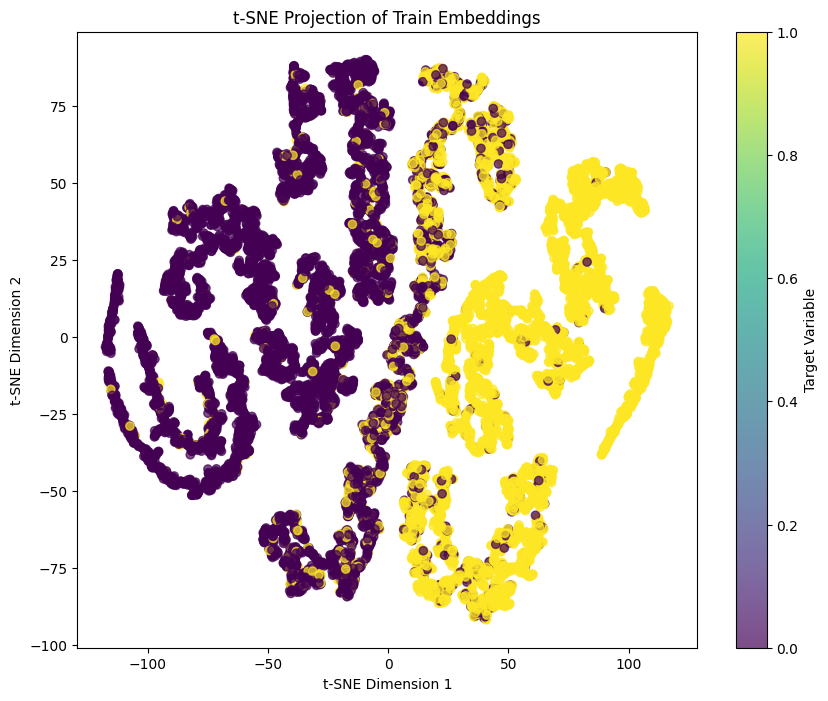

In [26]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 8))
scatter = plt.scatter(train_embeddings_2d[:, 0], train_embeddings_2d[:, 1], c=train_labels_list, cmap='viridis',
                      alpha=0.7)
plt.colorbar(scatter, label='Target Variable')
plt.title("t-SNE Projection of Train Embeddings")
plt.xlabel("t-SNE Dimension 1")
plt.ylabel("t-SNE Dimension 2")
plt.show()

In [27]:
test_embeddings = []
test_labels_list = []

In [28]:
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs = inputs.to(config.DEVICE)
        outputs = model(inputs)
        test_embeddings.append(outputs.cpu().numpy())
        test_labels_list.append(labels.numpy())

test_embeddings = np.vstack(test_embeddings)
test_labels_list = np.hstack(test_labels_list)

In [30]:
import umap

reducer = umap.UMAP(n_neighbors=15, min_dist=0.1, n_components=2)
test_embeddings_2d = reducer.fit_transform(test_embeddings)

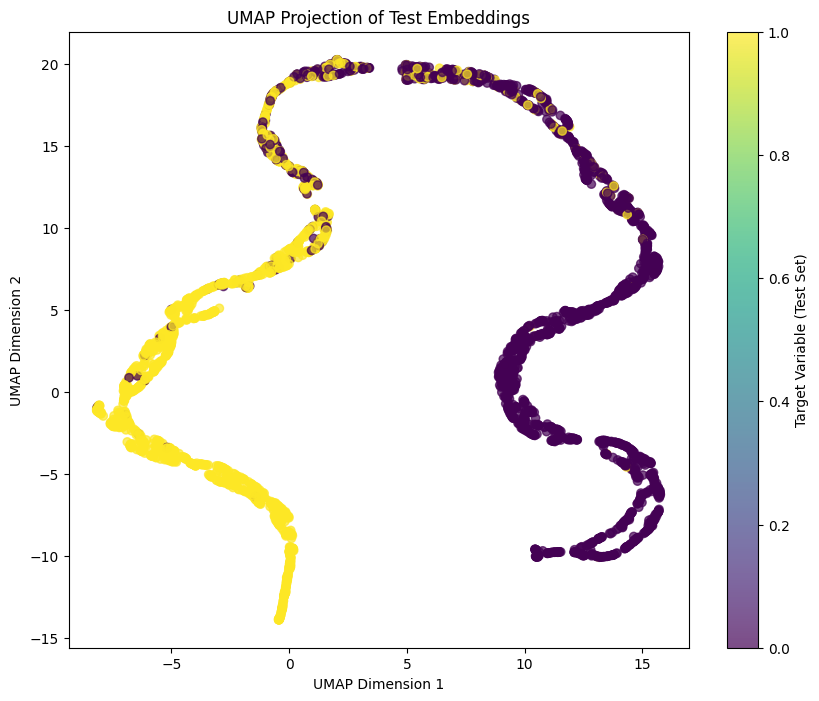

In [31]:
plt.figure(figsize=(10, 8))
scatter = plt.scatter(test_embeddings_2d[:, 0], test_embeddings_2d[:, 1], c=test_labels_list, cmap='viridis', alpha=0.7)
plt.colorbar(scatter, label='Target Variable (Test Set)')
plt.title("UMAP Projection of Test Embeddings")
plt.xlabel("UMAP Dimension 1")
plt.ylabel("UMAP Dimension 2")
plt.show()